<a href="https://colab.research.google.com/github/NM2509/Classification-of-astronomical-objects/blob/main/Classification_of_astronomical_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Libraries

In [1]:
# !pip install plotly

import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Visualisation
import plotly
import plotly.graph_objects as go
import plotly.express as px

# Iterators
import itertools

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn import model_selection, tree, metrics, pipeline
from sklearn import inspection, preprocessing, ensemble
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

Fix randomness

In [2]:
RS = 0
np.random.seed(1)

Data import

In [ ]:
X = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

assert list(X_test.columns) == list(X.columns)

y = pd.read_csv("y_train.csv")

## Predictions of the final model

Please see the code in the rest of the notebook for model selection and hyperparameter tuning steps

In [ ]:
final_rf_parameters = {'criterion': 'gini',
                       'max_depth': 34,
                       'max_features': 'sqrt',
                       "n_estimators": 300}

tuned_clf = ensemble.RandomForestClassifier(**final_rf_parameters, random_state=RS, n_jobs=-1,
                                            verbose=1)
tuned_clf.fit(X, y)
preds = tuned_clf.predict(X_test)

In [ ]:
preds_df = pd.DataFrame(preds, columns=["Class"])
preds_df.to_csv("predictions.csv", index_label="Index")

# EDA

## Exploring features

Setting defaults

In [ ]:
font = {'size': 12}
color = {'color': 'black'}
plt.rc('font', **font)
plt.rc('text', **color)
plt.rcParams['figure.dpi'] = 75

Data characteristics

In [ ]:
n, p = X.shape
print('The number of examples in the train set is: ' + format(n, ',d'))
print('The number of examples in the test set is: ' + format(y.shape[0], ',d'))
print('The number of features: {}'.format(p))

The number of examples in the train set is: 100,000
The number of examples in the test set is: 100,000
The number of features: 63


Features have different ranges, and hence it may be useful to scale the data

In [ ]:
print(X.describe().loc[['min', 'max']].round(2))

     airmass_g  airmass_i  airmass_r  airmass_u  airmass_z     colv    dec  \
min       1.00       1.00       1.00       1.00       1.00 -9999.00 -11.25   
max       1.88       1.85       1.84       1.86       1.87     2.52  68.73   

     extinction_g  extinction_i  extinction_r  ...  sky_u   sky_z  \
min          0.01          0.00          0.01  ...   0.68   10.31   
max         10.55          5.42          7.30  ...  24.27  360.48   

     spectroFlux_g  spectroFlux_i  spectroFlux_r  spectroFlux_u  \
min          -0.98          -2.82          -1.53         -26.90   
max       72270.13      260694.50      189664.30       13972.56   

     spectroFlux_z  wCoverage   waveMax  waveMin  
min         -50.48       0.00      0.00     0.00  
max      306515.70       0.46  10396.81  6820.25  

[2 rows x 63 columns]


Missing data

In [ ]:
print('The number of missing values in X_train dataset: ', sum(X.isna().sum()));
print('The number of missing values in y_train dataset: ', y.isna().sum()[0]);

The number of missing values in X_train dataset:  0
The number of missing values in y_train dataset:  0


We have 11 features, each of them with the subscripts U, G, R, I or Z, as well as 8 features without such subscripts. Let's divide them into those categories in order to better visualise it.

In [ ]:
# Features without photometric letters
feature_names = pd.DataFrame(X.head().columns)
feature_names.columns = ['no_photometric_letters']
no_photometric_letters = feature_names[-feature_names['no_photometric_letters'].str.contains('_')]

# Features with photometric letters
features_U = feature_names[feature_names['no_photometric_letters'].str.contains('_u')].reset_index(drop = True)
features_G = feature_names[feature_names['no_photometric_letters'].str.contains('_g')].reset_index(drop = True)
features_R = feature_names[feature_names['no_photometric_letters'].str.contains('_r')].reset_index(drop = True)
features_I = feature_names[feature_names['no_photometric_letters'].str.contains('_i')].reset_index(drop = True)
features_Z = feature_names[feature_names['no_photometric_letters'].str.contains('_z')].reset_index(drop = True)

features = pd.concat([features_U, features_G, features_R, features_I, features_Z], axis=1)
features.columns = ['Ultraviolet','Green','Red','Infrared','Z']

Relatively balanced data

In [ ]:
counts = y['class'].value_counts()
print('Galaxies represent {}% of the training dataset'.format(round(100* counts['GALAXY']/counts.sum(),1)))
print('Stars represent {}% of the training dataset'.format(round(100* counts['STAR']/counts.sum(),1)))
print('Quasars represent {}% of the training dataset'.format(round(100* counts['QSO']/counts.sum(),1)))

Galaxies represent 53.1% of the training dataset
Stars represent 36.3% of the training dataset
Quasars represent 10.6% of the training dataset


Exploring outliers

In [ ]:
# 1. Define outliers as those which have values over 5 standard deviations beyond the mean value
# 2. Create a list with outliers per each feature in X_train

outliers_list = []

for feature in list(X):
  outliers = np.abs(X[feature]-X[feature].mean()) > 5*X[feature].std()
  indices = outliers[outliers].index
  outliers_list.append(indices)

# Find features with outliers

features_with_outliers = []

for i in range(len(outliers_list)):
    if len(outliers_list[i]) > 0:
        features_with_outliers.append(i)

# 55 features have outliers
len(features_with_outliers)

55

Sky_u features outliers

In [ ]:
np.abs(X.sky_u-X.sky_u.mean()).sort_values(ascending = False).head(10)

47323    22.860467
90487    19.925457
36444    19.888207
77178    19.527677
84496    19.491577
15406    18.449747
57131    18.170287
81925    17.772477
17474    17.426057
27923    17.070177
Name: sky_u, dtype: float64

In [ ]:
np.abs(X.sky_u-X.sky_u.mean()).sort_values(ascending = False).tail(10)

93747    0.000049
71511    0.000046
98694    0.000044
31132    0.000040
36984    0.000035
42879    0.000021
15737    0.000020
12498    0.000020
54827    0.000016
63375    0.000010
Name: sky_u, dtype: float64

## Visualisation

From the below plots, we can see that a model such as random forest may be very useful. E.g. the very last feature shows that if the value of spectroFlux (Spectrum projected onto filter) is quite high, then it will have to be a star.

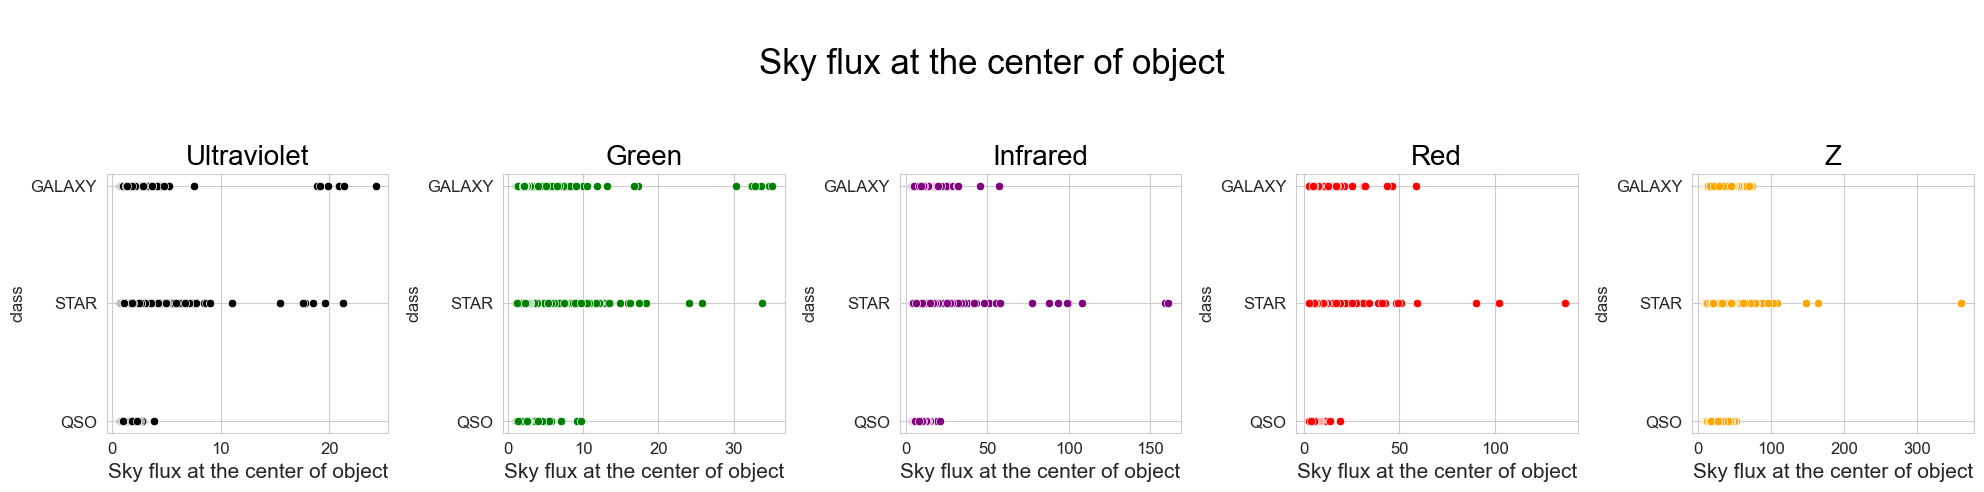

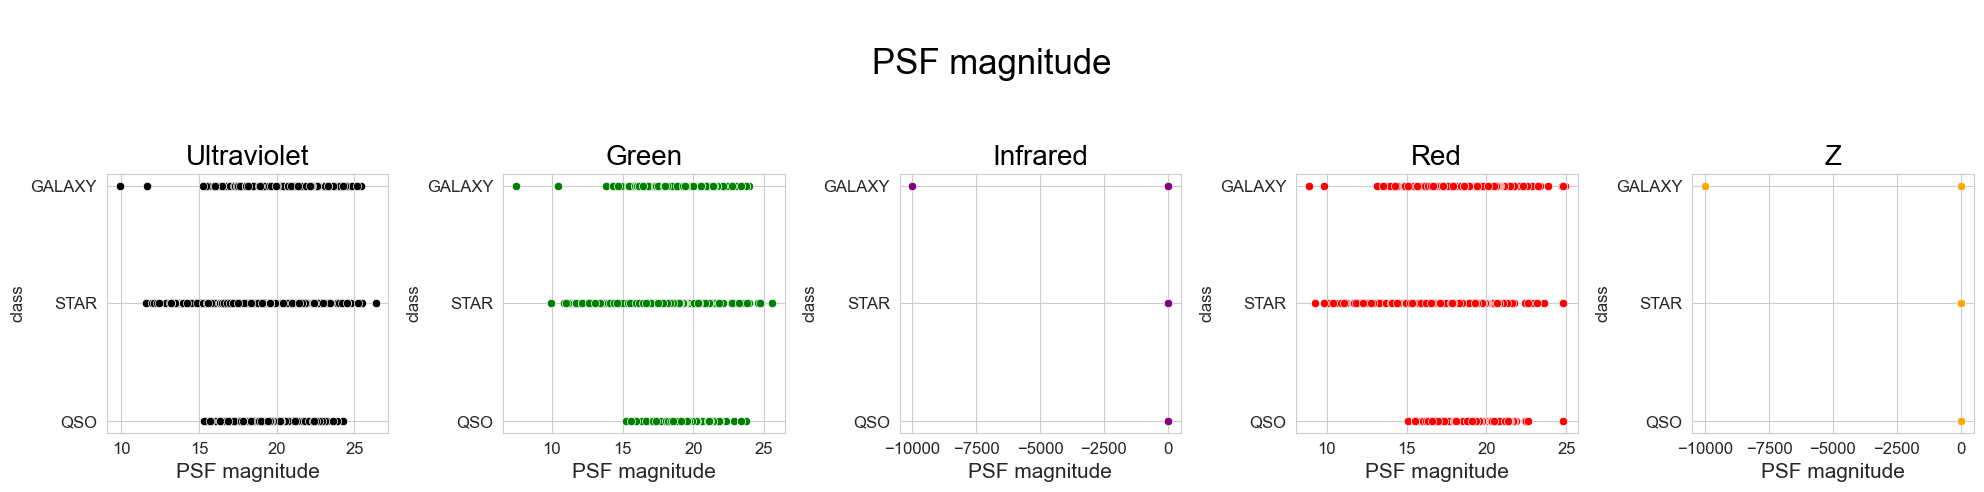

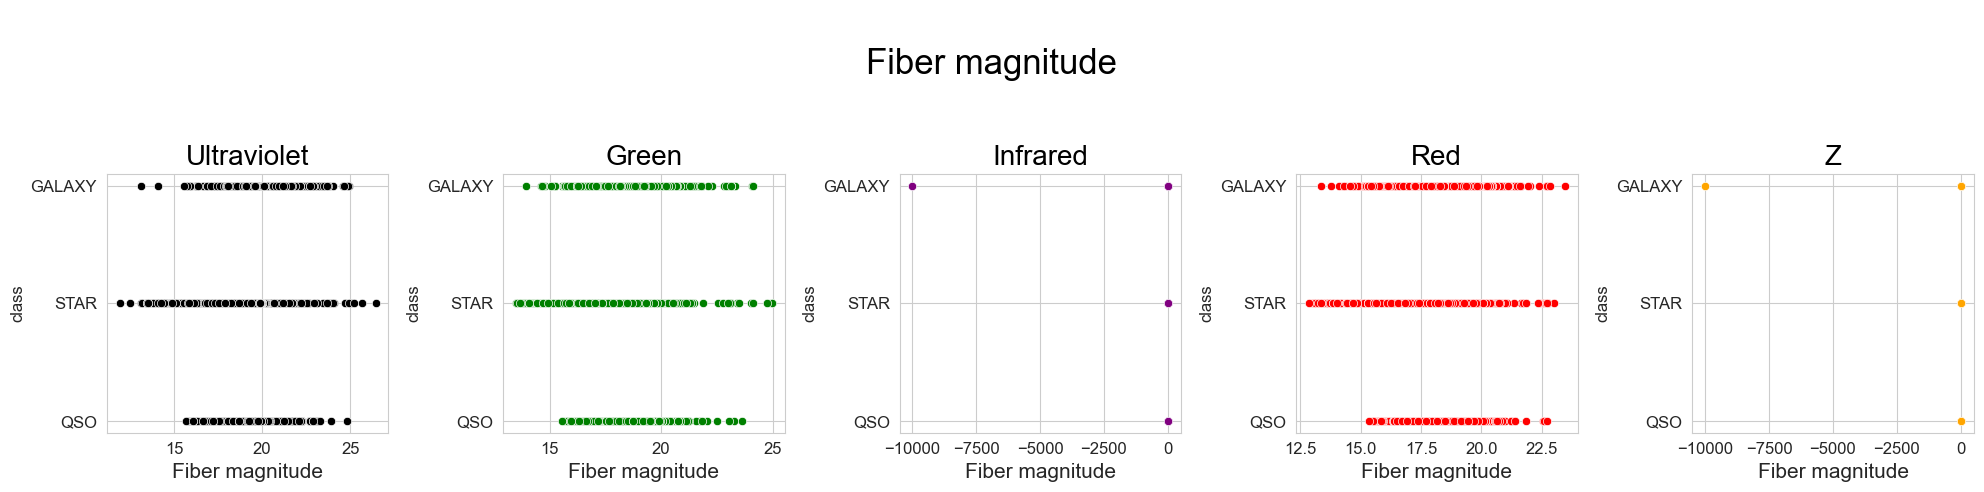

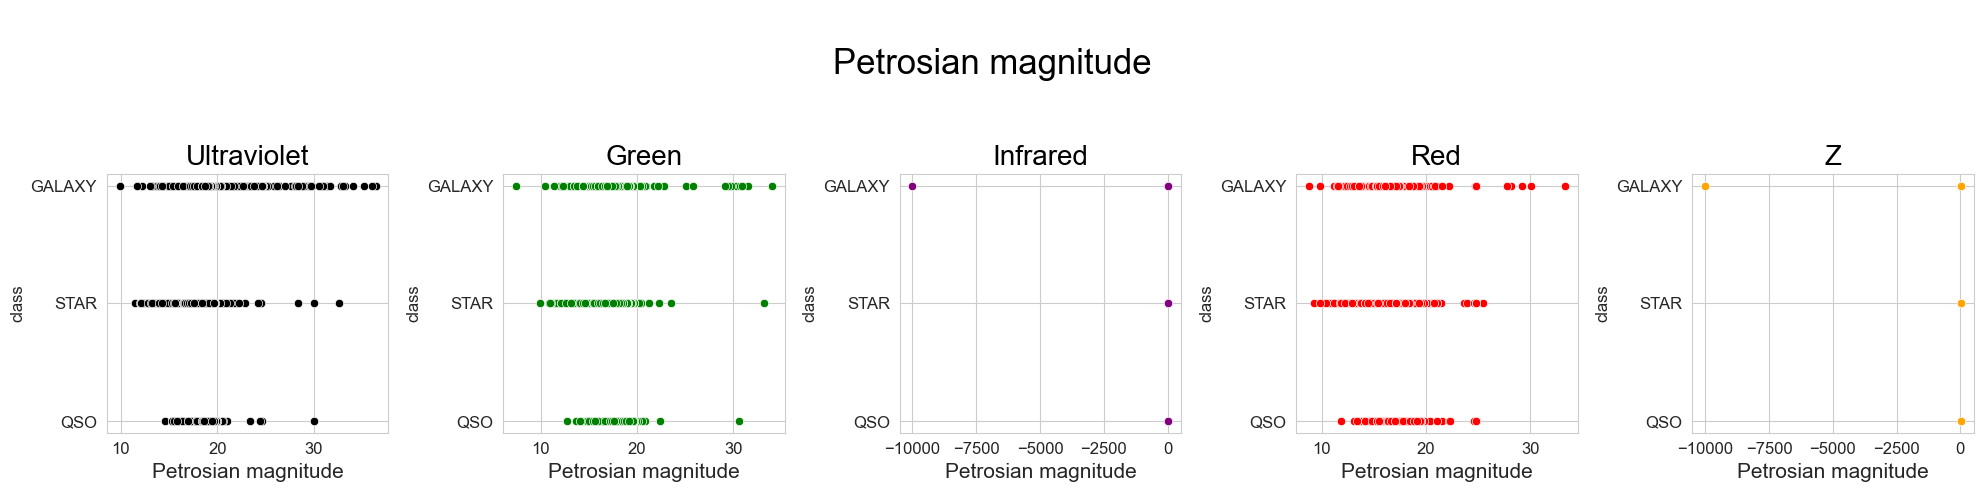

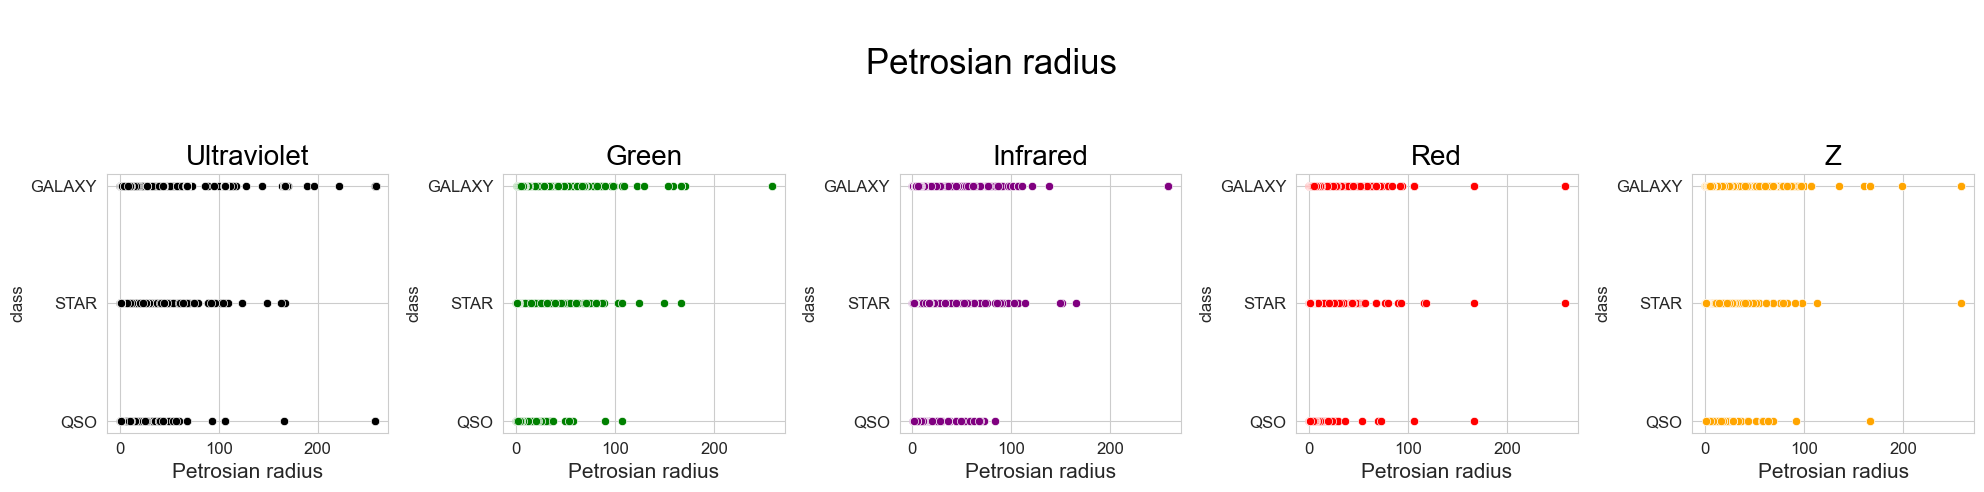

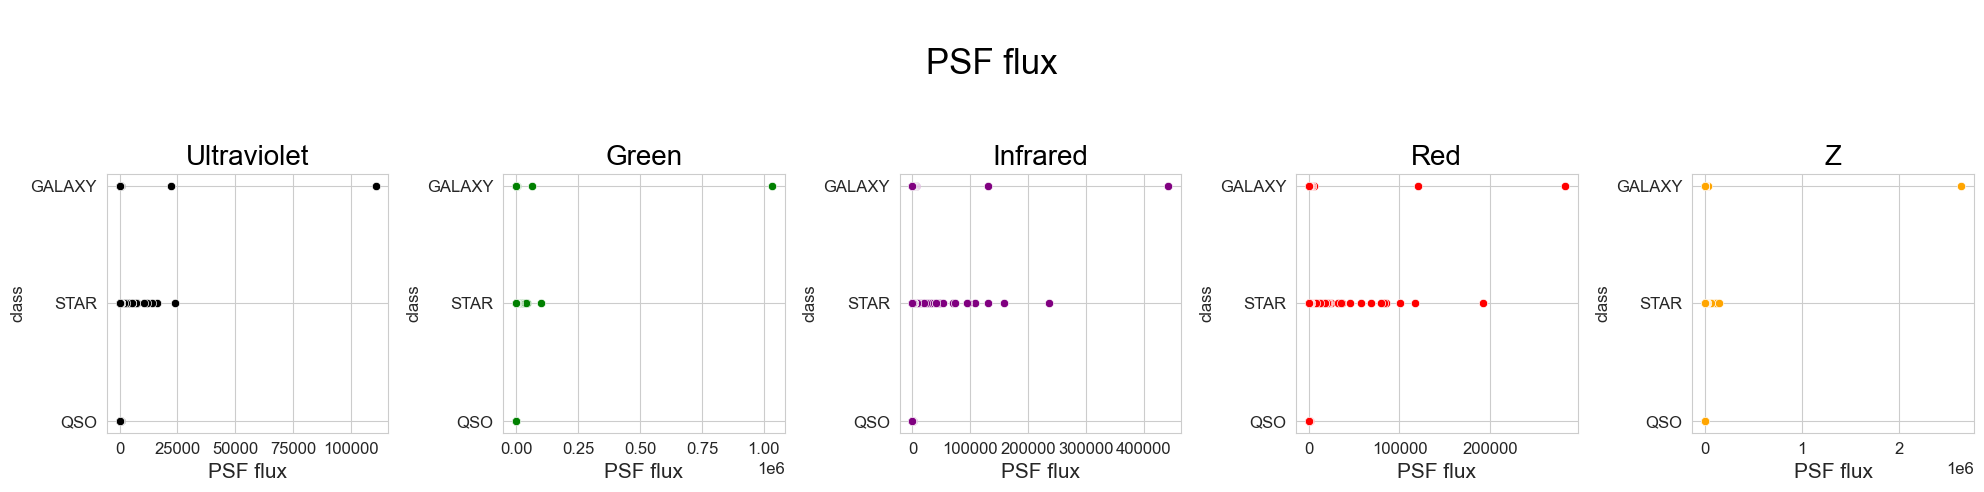

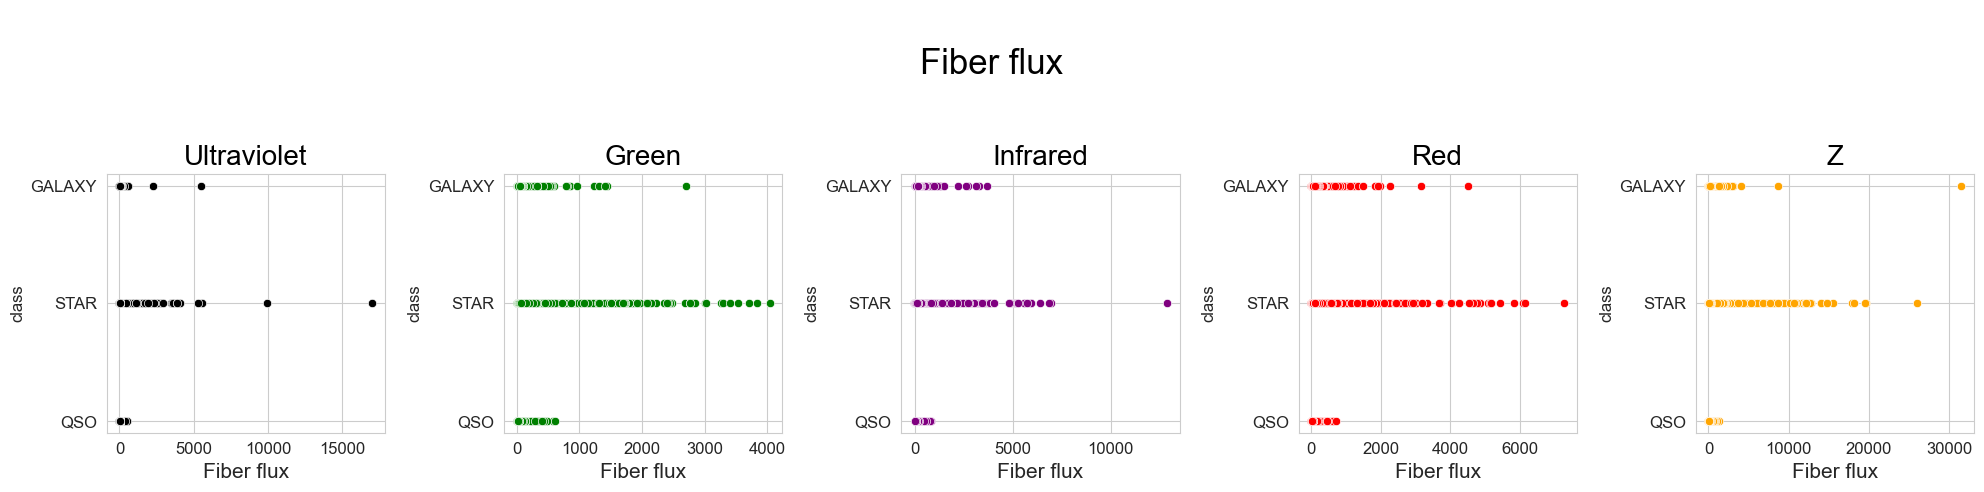

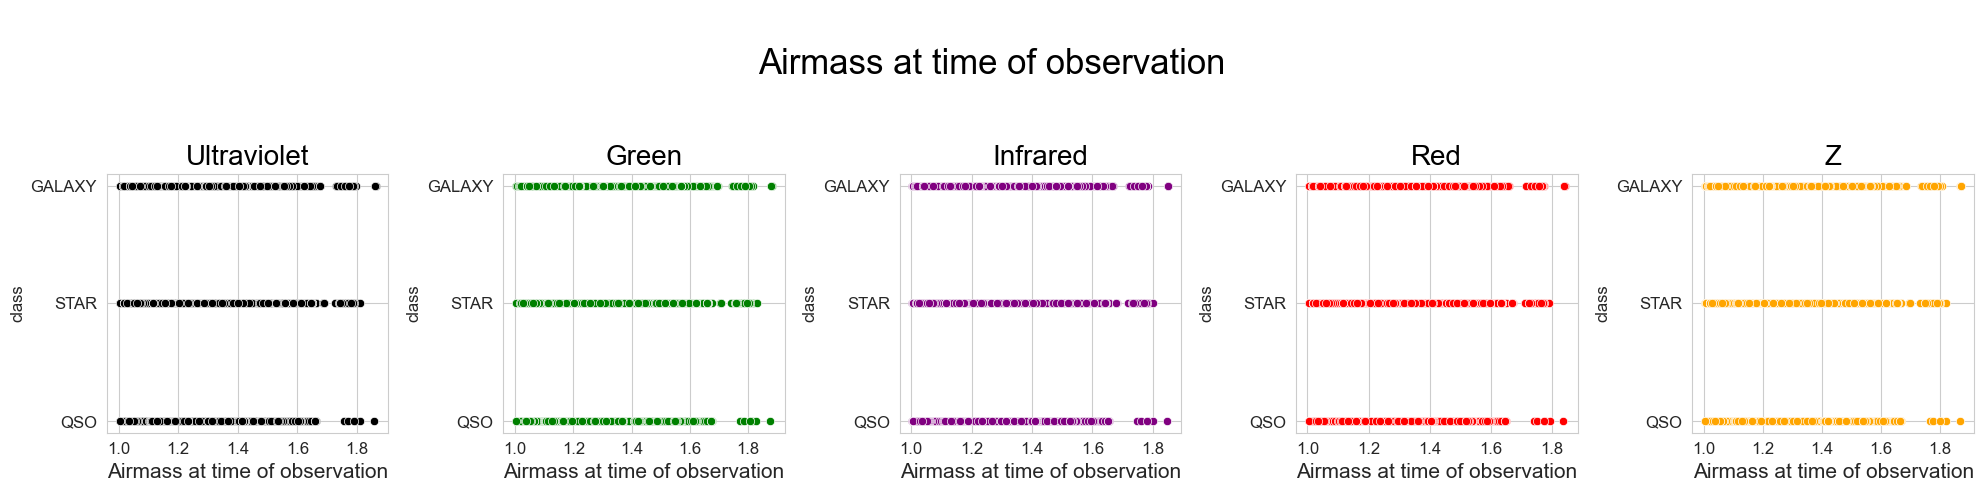

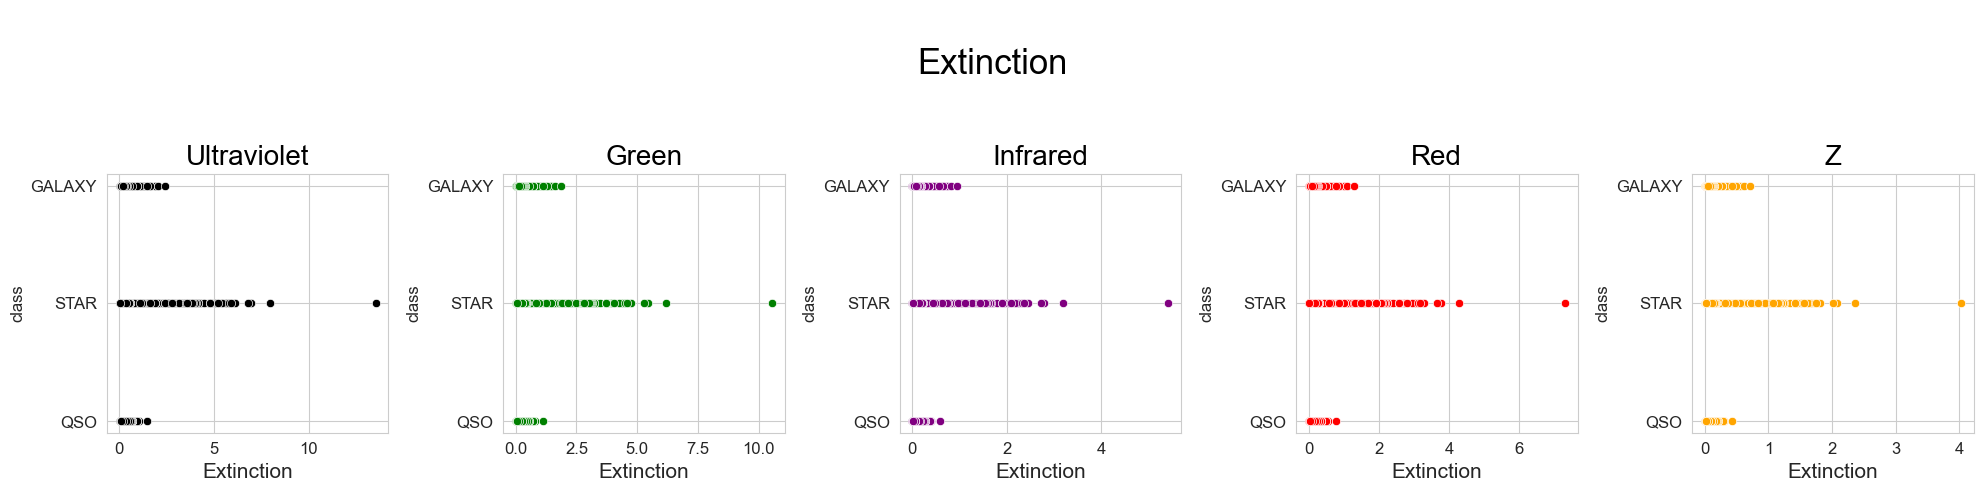

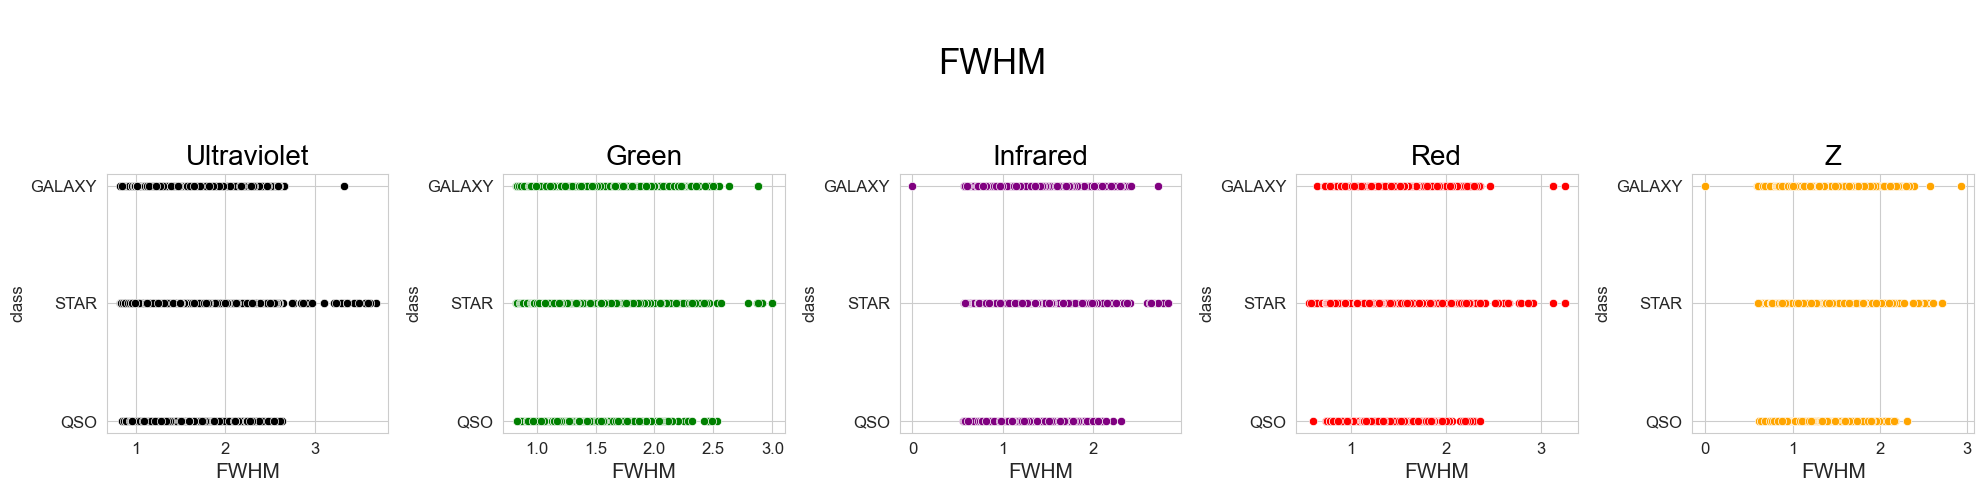

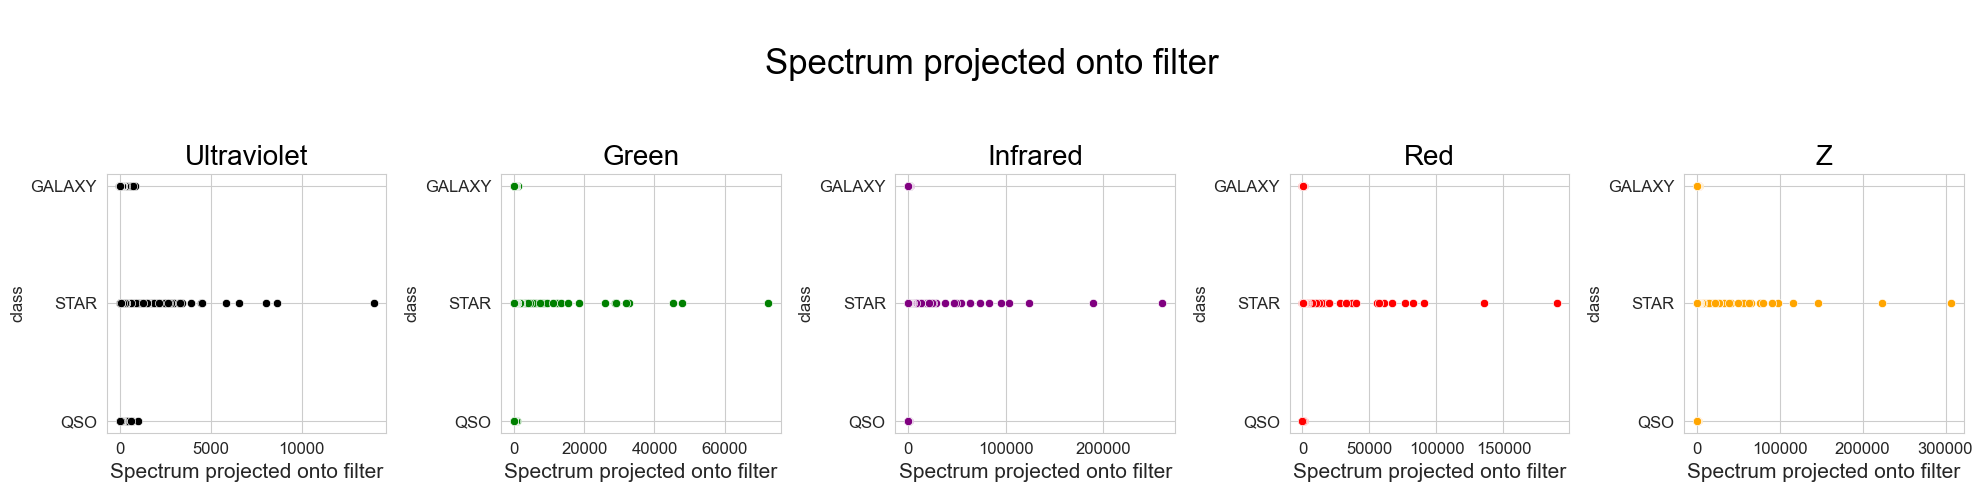

In [ ]:
plt.rcParams['figure.dpi'] = 100

data = pd.concat([X, y], axis = 1)

color = ['black','green','purple','red','orange']

feature_dict = {'Sky flux at the center of object':'sky',
                'PSF magnitude':'psfMag',
                'Fiber magnitude':'fiberMag',
                'Petrosian magnitude':'petroMag',
                'Petrosian radius':'petroRad',
                'PSF flux':'psfFlux',
                'Fiber flux':'fiberFlux',
                'Airmass at time of observation':'airmass',
                'Extinction':'extinction',
                'FWHM':'psffwhm',
                'Spectrum projected onto filter':'spectroFlux'}

for i in range(len(list(feature_dict))):
    title = list(feature_dict)[i]
    code = feature_dict.get(title)
    variables = [code + '_u', code + '_g', code + '_i', code + '_r', code + '_z']

    fig, axs = plt.subplots(1, len(variables), figsize=(20, 5))
    fig.suptitle('\n' + title + '\n', size=25)

    for j in range(len(variables)):
        sns.scatterplot(data=data, x=variables[j], y='class', ax=axs[j], color=color[j])
        name = features[features.isin([variables[j]])].any()
        axs[j].set_title(name.index[name].tolist()[0], size = 20)
        axs[j].set_xlabel(title, size = 15)
    plt.tight_layout()
    plt.show()

Features without photometric letters

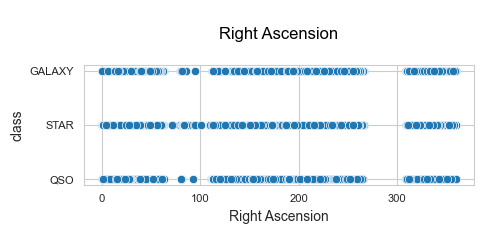

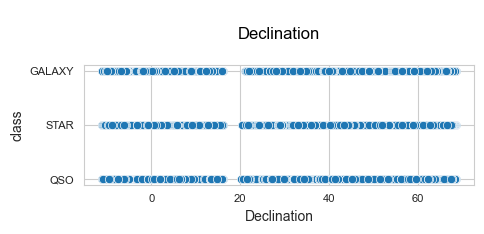

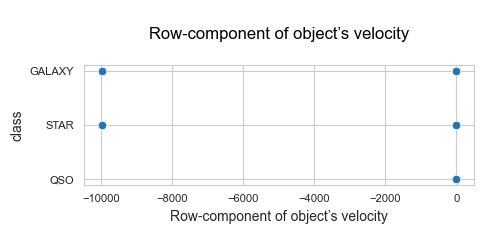

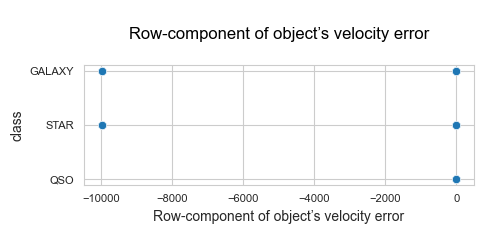

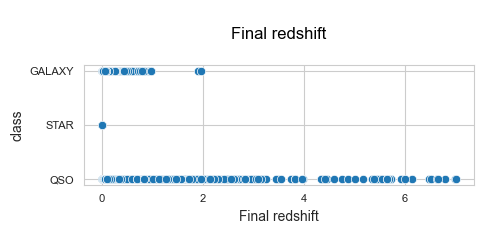

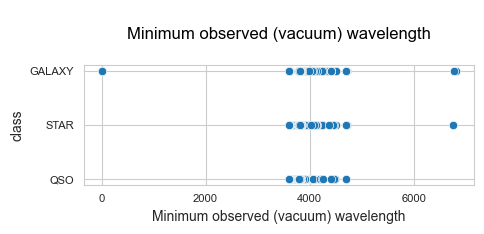

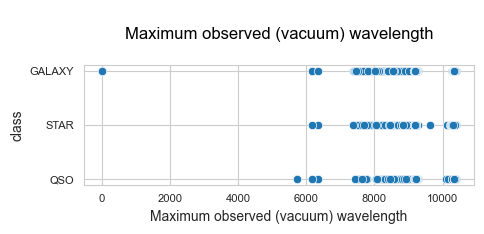

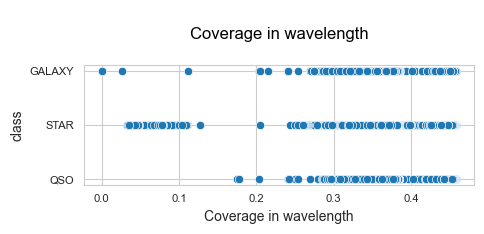

In [ ]:
names = list(feature_names[-feature_names['no_photometric_letters'].str.contains('_')]['no_photometric_letters'])

feature_dict = {'Right Ascension':'ra',
                'Declination':'dec',
                'Row-component of object’s velocity':'rowv',
                'Row-component of object’s velocity error':'colv',
                'Final redshift':'redshift',
                'Minimum observed (vacuum) wavelength':'waveMin',
                'Maximum observed (vacuum) wavelength':'waveMax',
                'Coverage in wavelength':'wCoverage',
                }

for i in range(len(names)):
    title = list(feature_dict)[i]
    code = feature_dict.get(title)

    plt.figure(figsize = (5,2.5));
    sns.scatterplot(data = data, x = code , y='class')
    plt.xlabel(title, size = 10)
    plt.ylabel('class', size = 10)
    plt.title('\n' + title + '\n', size=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

Correlations between variables to see if we should transform them

In [ ]:
correlations = X.corr()
# correlations.style.background_gradient(axis=0)

Features with correlations above 0.999

In [ ]:
corr_df = correlations.unstack().reset_index()
corr_df.columns = ['feature_1', 'feature_2', 'correlation']
high_corr_df = corr_df[(corr_df['correlation'] > 0.999) & (corr_df['feature_1'] < corr_df['feature_2'])]
print(high_corr_df)

         feature_1     feature_2  correlation
3        airmass_g     airmass_u     0.999551
4        airmass_g     airmass_z     0.999890
65       airmass_i     airmass_r     0.999877
66       airmass_i     airmass_u     0.999881
67       airmass_i     airmass_z     0.999534
129      airmass_r     airmass_u     0.999517
193      airmass_u     airmass_z     0.999886
364           colv          rowv     1.000000
449   extinction_g  extinction_i     1.000000
450   extinction_g  extinction_r     1.000000
451   extinction_g  extinction_u     1.000000
452   extinction_g  extinction_z     1.000000
513   extinction_i  extinction_r     1.000000
514   extinction_i  extinction_u     1.000000
515   extinction_i  extinction_z     1.000000
577   extinction_r  extinction_u     1.000000
578   extinction_r  extinction_z     1.000000
641   extinction_u  extinction_z     1.000000
1155    fiberMag_i    fiberMag_z     0.999983
1157    fiberMag_i    petroMag_i     0.999666
1160    fiberMag_i    petroMag_z  

Usual ways of proceeding in case of multicollinearity:
1. PCA
2. Removing highly correlated features
3. Adding regularization

Exploring Airmass variable - we can see that it is not a perfect corelation, and there are some differences

In [ ]:
fig = px.scatter_3d(data, x='airmass_u', y='airmass_z', z='airmass_g',
              color='class')
fig.update_layout(scene_camera=dict(eye=dict(x=1.8, y=-1.8, z=0.5),
                                    up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0)),
                  scene=dict(xaxis=dict(title='airmass_u'),
                             yaxis=dict(title='airmass_z'),
                             zaxis=dict(title='airmass_g')))
fig.show()

In [ ]:
fig = px.scatter_3d(data, x='airmass_u', y='airmass_r', z='airmass_i',
              color='class')
fig.update_layout(scene_camera=dict(eye=dict(x=1.8, y=-1.8, z=0.5),
                                    up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0)),
                  scene=dict(xaxis=dict(title='airmass_u'),
                             yaxis=dict(title='airmass_r'),
                             zaxis=dict(title='airmass_i')))
fig.show()

Exploring Extinction variable

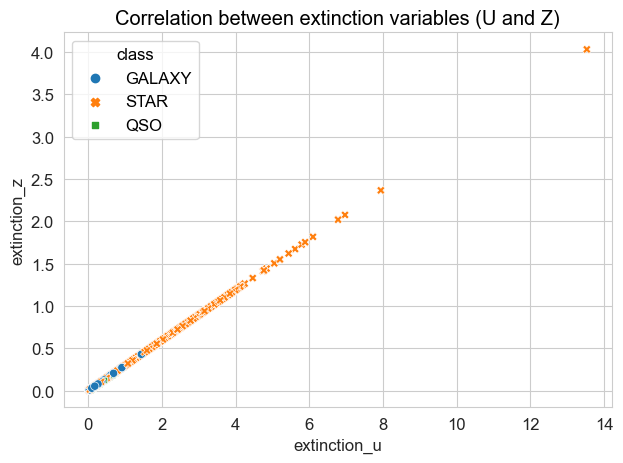

In [ ]:
plt.rcParams['figure.dpi'] = 100
plt.figure();
sns.scatterplot(data = data, x = 'extinction_u', y = 'extinction_z', hue = 'class', style = 'class')
plt.title('Correlation between extinction variables (U and Z)')
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter_3d(data, x='extinction_u', y='extinction_z', z='extinction_g',
              color='class')
fig.update_layout(scene_camera=dict(eye=dict(x=1.8, y=-1.8, z=0.5),
                                    up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0)),
                  scene=dict(xaxis=dict(title='extinction_u'),
                             yaxis=dict(title='extinction_z'),
                             zaxis=dict(title='extinction_g')))
fig.show()

In [ ]:
fig = px.scatter_3d(data, x='extinction_u', y='extinction_r', z='extinction_i', color='class')
fig.update_layout(scene_camera=dict(eye=dict(x=1.8, y=-1.8, z=0.5),
                                    up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=0)),
                  scene=dict(xaxis=dict(title='extinction_u'),
                             yaxis=dict(title='extinction_r'),
                             zaxis=dict(title='extinction_i')))
fig.show()

Exploring Row-component of object’s velocity (rowv) and Row-component of object’s velocity error (colv)

Even though rowv and colv are being shown to have correlation 1, after plotting them we can see that it is not true. We were seeing correlation 1, because there are a few observations with very high negative values (of -9,999), which, compared with the usual values in the range of -1.5 and 1.5 makes the correlation seem to be 1 (which it is when rounding to 6 decimal places).

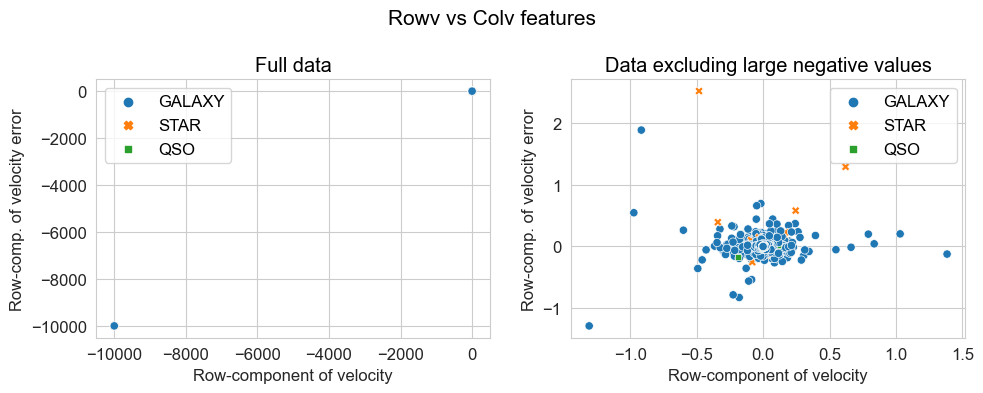

In [ ]:
plt.rcParams['figure.dpi'] = 100
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
fig.suptitle('Rowv vs Colv features', size=15)

sns.scatterplot(data=data, x='rowv', y='colv', hue = 'class', style = 'class', ax=axs[0])
axs[0].set_title('Full data')
axs[0].legend(title = None)
axs[0].set(xlabel='Row-component of velocity', ylabel='Row-comp. of velocity error')

sns.scatterplot(data=data[data['rowv'] > -9998], x='rowv', y='colv', hue = 'class', style='class', ax=axs[1])
axs[1].legend(loc='upper right')
axs[1].set_title('Data excluding large negative values')
axs[1].set(xlabel='Row-component of velocity', ylabel='Row-comp. of velocity error')

plt.tight_layout()
plt.show()

In [ ]:
X['rowv'].sort_values().head(10)

69391   -9999.000000
17964   -9999.000000
9388    -9999.000000
83687   -9999.000000
34186   -9999.000000
56975   -9999.000000
63781   -9999.000000
87194      -1.311074
82216      -0.974533
64563      -0.918284
Name: rowv, dtype: float64

In [ ]:
X['colv'].sort_values().head(10)

17964   -9999.000000
63781   -9999.000000
56975   -9999.000000
9388    -9999.000000
69391   -9999.000000
34186   -9999.000000
83687   -9999.000000
87194      -1.286461
42415      -0.826392
67690      -0.783364
Name: colv, dtype: float64

## PCA


In [ ]:
cols = X.columns
standard_scaler = preprocessing.StandardScaler()
# using the entire dataset, scaling here
# refering to this as X_sc, but it was previously X_train (that variable had been overwritten)

# this ensures that X_sc is still a dataframe, because fit_transform
# only returns a matrix, so we need to squish that back into the dataframe.
X_sc = X.copy()
X_sc[:] = standard_scaler.fit_transform(X_sc[:]) #scaling data

In [ ]:
K = 40 # Number of principal components
pca = PCA(n_components = K)
pca.fit(X_sc) #  Calculate the PCs and eigenvalues of the data matrix X

PCA(n_components=40)

In [ ]:
 # Principal components
V = pd.DataFrame(data=pca.components_.T, index=cols)
# print('Principal components:\n', V)

# Eigenvalues
lam = pca.explained_variance_
# print('\n Eigenvalues/variance of the projections:\n', lam)


Proportion of variance explained:
  [0.19100619 0.11758088 0.09539318 0.09232331 0.07671576]

Total variance explained with 5 PCs:
  0.5730193111607441


Text(0, 0.5, 'Prop. Explained variance')

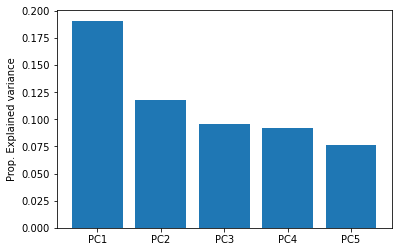

In [ ]:
# Proportion of variance explained
Normalised_lam = pca.explained_variance_ratio_
print('\nProportion of variance explained:\n ',Normalised_lam[:5])
print('\nTotal variance explained with 5 PCs:\n ',Normalised_lam[:5].sum(axis=0) )
plt.figure()
plt.bar(['PC1','PC2','PC3','PC4','PC5'], Normalised_lam[:5])
plt.ylabel('Prop. Explained variance')

In [ ]:
# Default plotting parameters
font = {'size'   : 18}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

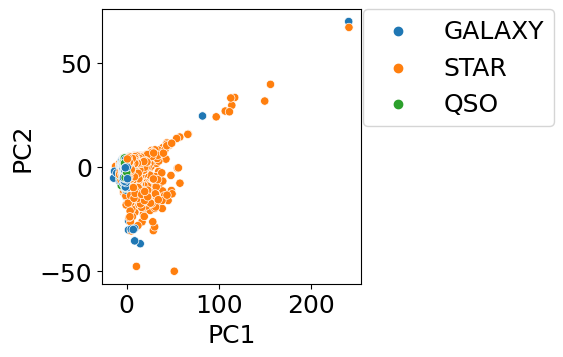

In [ ]:
# Full scaled data
train_set = np.array(X_sc)
pca.fit(train_set)
Z_pca = pca.transform(train_set)

# Compute and plot the projections onto the PCs
space_object = pd.concat([pd.DataFrame(Z_pca[:,:5], columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']), y], axis=1)
plt.figure()
sns.scatterplot(x=space_object['PC1'], y=space_object['PC2'],
                hue = space_object['class'], markers=["o", "s", "D", "d"])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()
# Zooming in does not offer much clarity
plt.xlim(-10, 50)

In [ ]:
variance_ratios = pca.explained_variance_ratio_
variance_ratios_df = pd.DataFrame(variance_ratios, columns=['Variance Explained by each PC'])
variance_ratios_df['Cumulatively explaind share'] = variance_ratios_df['Variance Explained by each PC'].cumsum()
variance_ratios_df.iloc[28:31,:]

,Variance Explained by each PC,cumulative average
28,0.002437,0.986813
29,0.002306,0.989120
30,0.001969,0.991088


31 components are required for 99% of the variance to be explained

In [ ]:
V_31_PCs = V.iloc[:,:31]
V_31_PCs['total'] = abs(V_31_PCs).sum(axis=1)
V_31_PCs.sort_values(by='total', ascending = False, inplace=True)
variable_contributions = pd.DataFrame(V_31_PCs['total'])
variable_contributions = (variable_contributions/V_31_PCs['total'].sum(axis=0))*100
variable_contributions.columns = ['Percentage of total weighting']

In [ ]:
variable_contributions.head(5)

,Percentage of total weighting
redshift,2.835870
petroMag_u,2.821566
sky_u,2.625100
petroRad_g,2.572391
petroRad_i,2.547231


Redshift describes the largest proportion of variance as it contributes to the PCs the most

## LDA

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RS)

LDAclf_digit = LinearDiscriminantAnalysis()
LDAclf_digit.fit(X_train, y_train)
lda_accuracy_training = LDAclf_digit.score(X_train,y_train)
lda_accuracy_test = LDAclf_digit.score(X_val,y_val)
print('Accuracy on Training Set: ', lda_accuracy_training)
print('Accuracy on Test Set: ', lda_accuracy_test)

Accuracy on Training Set:  0.97612
Accuracy on Test Set:  0.97508


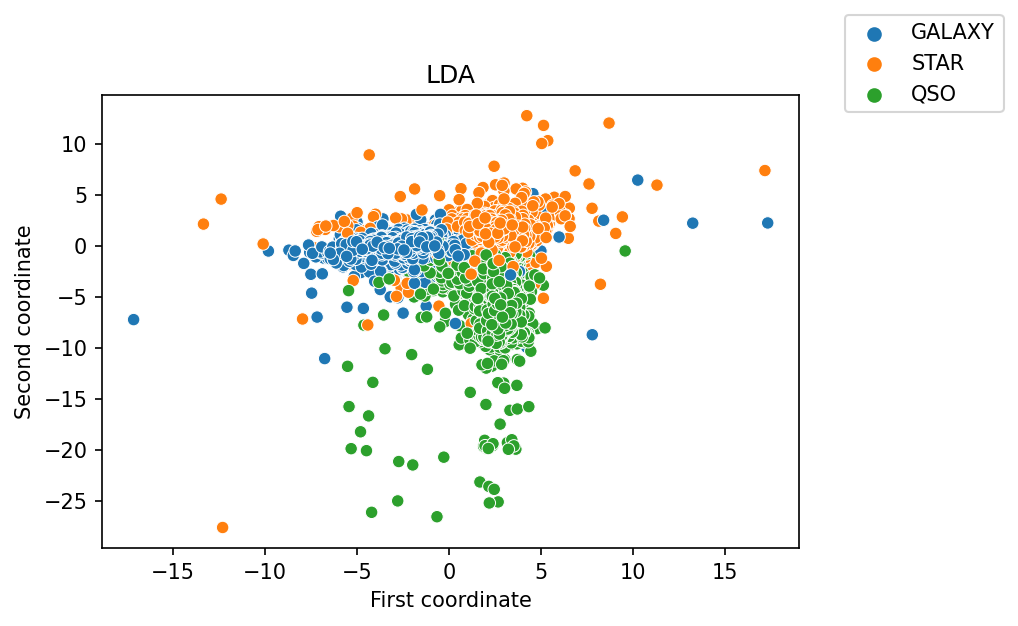

In [ ]:
Z_lda = LDAclf_digit.transform(X_train)

plt.rcParams['figure.dpi'] = 150
plt.figure()
sns.scatterplot(x=Z_lda[:,0], y=Z_lda[:,1], hue= y_train.squeeze())
plt.xlabel('First coordinate')
plt.ylabel('Second coordinate')
plt.title('LDA')
plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left');

# Model Selection

## KNN

In [ ]:
X_sc = X.copy()
X_sc.drop(['extinction_i','extinction_g','extinction_r','extinction_u'],
          inplace=True, axis=1)

# scaling data
scaler = preprocessing.StandardScaler()
X_sc[:] = scaler.fit_transform(X_sc[:])

# Reducing dimensionality didn't improve the model's performance
'''
pca = PCA(n_components = 31)
pca = pca.fit(X_sc)
X_pca = pca.transform(X_sc)
'''

X_tr_sc, X_val_sc, y_tr_sc, y_val_sc = model_selection.train_test_split(X_sc, y, test_size=0.25, random_state=RS)

In [ ]:
k = 6
knnclf = KNeighborsClassifier(n_neighbors=k)
knnclf.fit(X_tr_sc, y_tr_sc)

# Return an empirical risk under 0-1 loss
print("Accuracy on train set:", knnclf.score(X_tr_sc, y_tr_sc))
print("Accuracy on validation set:", knnclf.score(X_val_sc, y_val_sc))

Accuracy on train set: 0.97984
Accuracy on validation set: 0.9728


Try with different numbers of neighbours:

In [ ]:
k_all = list(np.arange(2,100,4))

emprisk_train = np.zeros(shape=len(k_all))
emprisk_val = np.zeros(shape=len(k_all))
for (i, k) in enumerate(k_all):
    knnclf = KNeighborsClassifier(n_neighbors=k)
    knnclf.fit(X_tr_sc, y_tr_sc)
    # Return an empirical risk
    emprisk_train[i] = 1- knnclf.score(X_tr_sc, y_tr_sc)
    emprisk_val[i] = 1- knnclf.score(X_val_sc, y_val_sc)

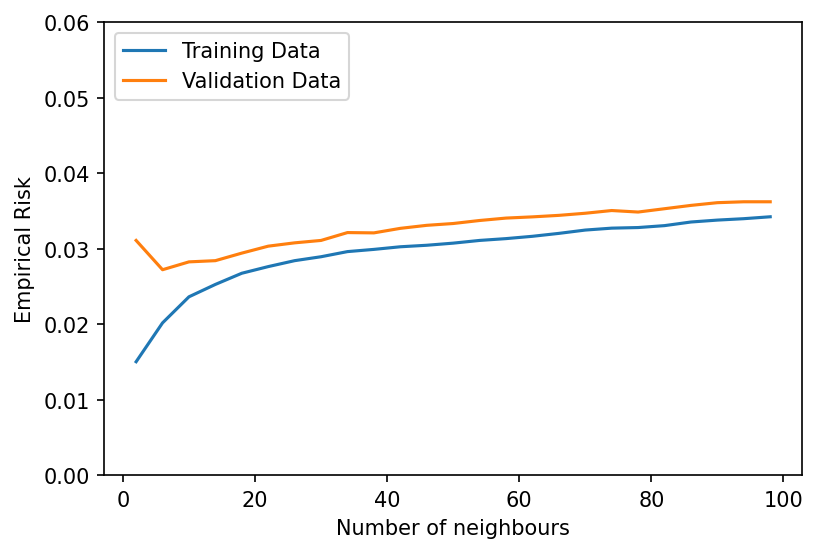

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.figure()
plt.plot(k_all,emprisk_train, label='Training Data')
plt.plot(k_all,emprisk_val, label='Validation Data')
plt.ylim([0,.06])
plt.xlabel('Number of neighbours')
plt.ylabel('Empirical Risk')
plt.legend(loc='upper left');

# delete all data created for this section from namespace and memory
del X_tr_sc, X_val_sc, y_tr_sc, y_val_sc, X_sc

## Multilayer perceptron

Data pre-processing

In [ ]:
# X is the full dataset, and y the full label vector
X_train_nn = X.copy()

# Dropping features with correlation = 1 exactly
X_train_nn.drop(['extinction_i','extinction_g','extinction_r','extinction_u'], inplace=True, axis=1)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)

# Train / validation split
X_train_split, X_val_split, y_train_split, y_val_split = model_selection.train_test_split(
    X_train_scaled, y, test_size=0.25, random_state=RS)

Grid search for the best activation function, number of neurons, and regularizer value

In [ ]:
param_grid = {'activation': ['logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(2,1), (3,1), (4,1), (5,1), (10,1), (15,1), (20,1), (50,1)],
              'alpha': [0.01, 0.1, 1]
              }

classifier = MLPClassifier(random_state=RS, max_iter=1000, solver='adam', verbose = True)

grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1, verbose = 2)
grid_search.fit(X_train_split, y_train_split)

print("Activation:", grid_search.best_params_['activation'])
print("Number of neurons:", grid_search.best_params_['hidden_layer_sizes'])
print("Regularizer:", grid_search.best_params_['alpha'])
print("Accuracy:", grid_search.best_score_)

In [ ]:
# Deleting the datasets created for the neural network section from memory
del X_train_nn, X_train_split, X_val_split, y_train_split, y_val_split

## Decision Tree

In [ ]:
# reset plt settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [ ]:
# Fit default decision tree, compute accuracy and check some attributes
X_tr, X_val, y_tr, y_val = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=RS)

In [ ]:
clf = tree.DecisionTreeClassifier(random_state=RS)
clf.fit(X_tr, y_tr)
y_hat = clf.predict(X_val)
acc = metrics.accuracy_score(y_hat, y_val)
print(f"Decision Tree with defaults has accuracy {acc:.4f}")
print(f"Decision Tree with defaults has depth {clf.get_depth()}")
print(f"Decision Tree with defaults has {clf.get_n_leaves()} leaves")

# Now, investigate why the splitting stopped.
# The nodes are expanded until all leaves are pure or
# until all leaves contain less than 'min_samples_split' samples.
# I suppose they stopped splitting because all nodes are pure. Let's check.

leaf_impurities = []
# iterate over all nodes
for i, impurity in enumerate(clf.tree_.impurity):
    # check if we have a leaf node
    if clf.tree_.children_left[i] == -1 and clf.tree_.children_right[i] == -1:
        leaf_impurities.append(impurity)

print(f"Highest impurity of leaf nodes: {np.max(leaf_impurities):.6f}" +
      " after fitting Decision tree with defaults."
      )

# With the default settings, all nodes are pure, but we might get
# a smaller generalization error when we allow for some non-pure leaves.

# Define the parameter grid to search
# check the depths [5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]
param_grid = {'max_depth': list(range(5, 39, 3))}
decision_tree = tree.DecisionTreeClassifier(random_state=RS)
grid_search = GridSearchCV(verbose=2, estimator=decision_tree,
                           param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_tr, y_tr["class"].ravel())
best_parameter = grid_search.best_params_["max_depth"]
print(f"Best parameters: {best_parameter}")

clf_tuned = tree.DecisionTreeClassifier(random_state=RS,
                                        max_depth=best_parameter)

clf_tuned.fit(X_tr, y_tr)
y_hat = clf_tuned.predict(X_val)
acc = metrics.accuracy_score(y_hat, y_val)
print(f"Tuned Decision Tree Classifier has accuracy {acc:.4f}")

Decision Tree with defaults has accuracy 0.9878
Decision Tree with defaults has depth 41
Decision Tree with defaults has 550 leaves


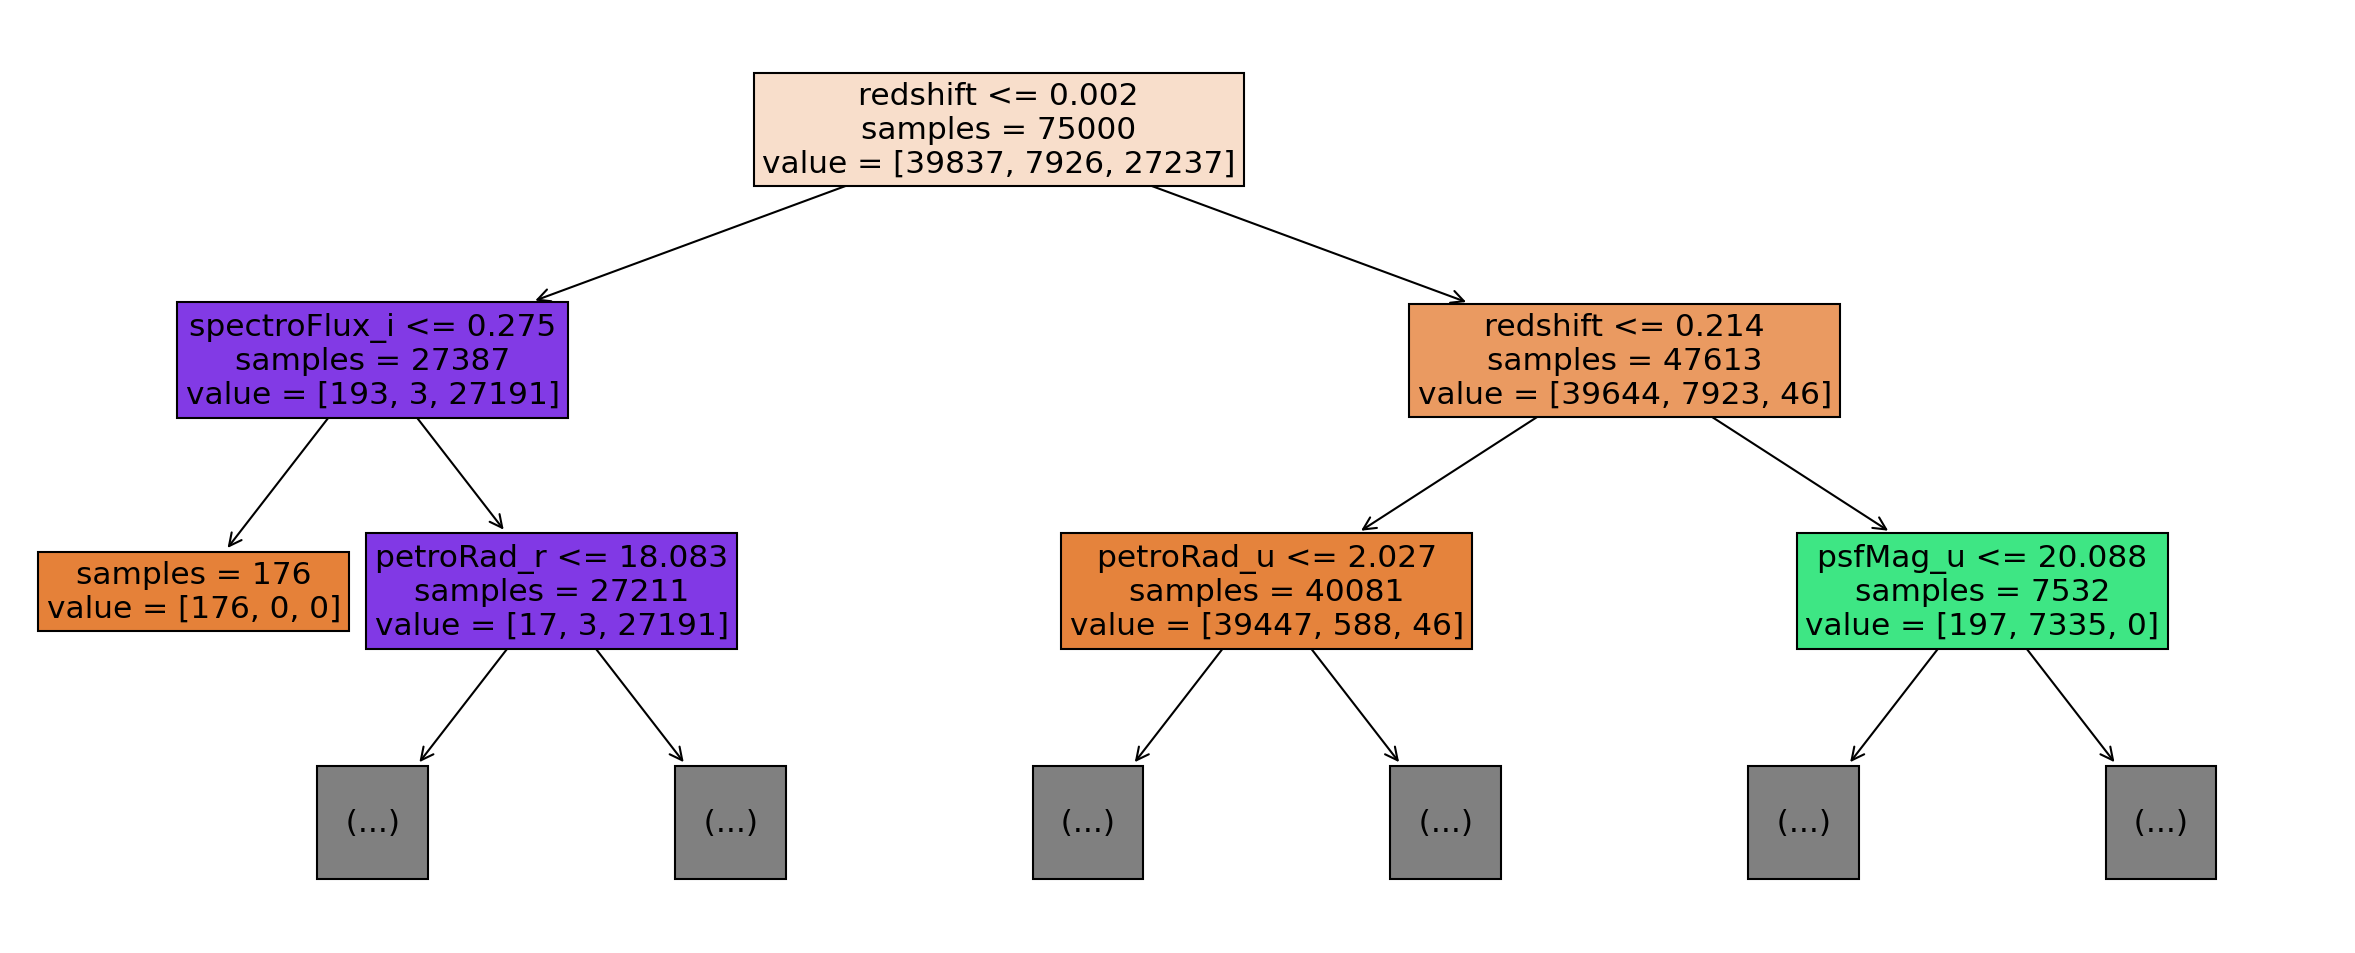

In [ ]:
classifier = tree.DecisionTreeClassifier(random_state=RS, max_depth = 8)
classifier.fit(X_tr,y_tr["class"].ravel())
names = X_tr.columns

plt.rcParams['figure.dpi'] = 150
plt.figure(figsize=(20, 8))
plot_tree(classifier, max_depth=2, filled=True, feature_names = names, fontsize=15, impurity=False);

## Random Forest

In [ ]:
X_tr, X_val, y_tr, y_val = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=RS)

param_grid = {'max_depth': list(range(4, 63, 2)),
              'criterion': ['gini', 'entropy']
              }

rd_clf = ensemble.RandomForestClassifier(random_state=RS, n_jobs=-1, n_estimators = 300,
                                         max_features = 'sqrt')
grid_search = model_selection.GridSearchCV(verbose=2, estimator=rd_clf, param_grid=param_grid,
                                           cv=5, n_jobs=-1)

grid_search.fit(X_tr, y_tr["class"].ravel())

print("Maximum depth:", grid_search.best_params_['max_depth'])
print("Impurity measure:", grid_search.best_params_['criterion'])
print("Accuracy:", grid_search.best_score_)


In [ ]:
final_rf_parameters = {'criterion': 'gini',
                       'max_depth': 34,
                       'max_features': 'sqrt',
                       "n_estimators": 300}

tuned_clf = ensemble.RandomForestClassifier(**final_rf_parameters, random_state=RS, n_jobs=-1,
                                            verbose=1)
tuned_clf.fit(X_tr, y_tr)
y_hat_rf = tuned_clf.predict(X_val)
print(f"Accuracy of fine tuned classifer: {metrics.accuracy_score(y_hat_rf, y_val):1.5f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.2s


Accuracy of fine tuned classifer: 0.99328


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


# Final Model Analysis (Random Forest)

The model needs standardized data with equal number of unique values to give good feature importance values. Hence, for the final model, standardize the data and add small Gaussian noise with $\sigma^2 = 1\cdot 10^{-5}$

In [ ]:
def add_noise(X):
    return X + np.random.normal(0, 1e-5, X.shape)

final_model = pipeline.Pipeline([
    ("scaler", StandardScaler()),
    ("noiser", preprocessing.FunctionTransformer(add_noise, check_inverse=False)),
    ("model", ensemble.RandomForestClassifier(**final_rf_parameters, random_state=1,
                                              n_jobs=-1, verbose=True, oob_score=True))
    ], verbose=True)

## Performance Analysis

In [ ]:
X_tr, X_val, y_tr, y_val = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=RS)

final_model.fit(X_tr, y_tr)
final_y_hat = final_model.predict(X_val)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing noiser, total=   0.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.0s finished


[Pipeline] ............. (step 3 of 3) Processing model, total=  33.4s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


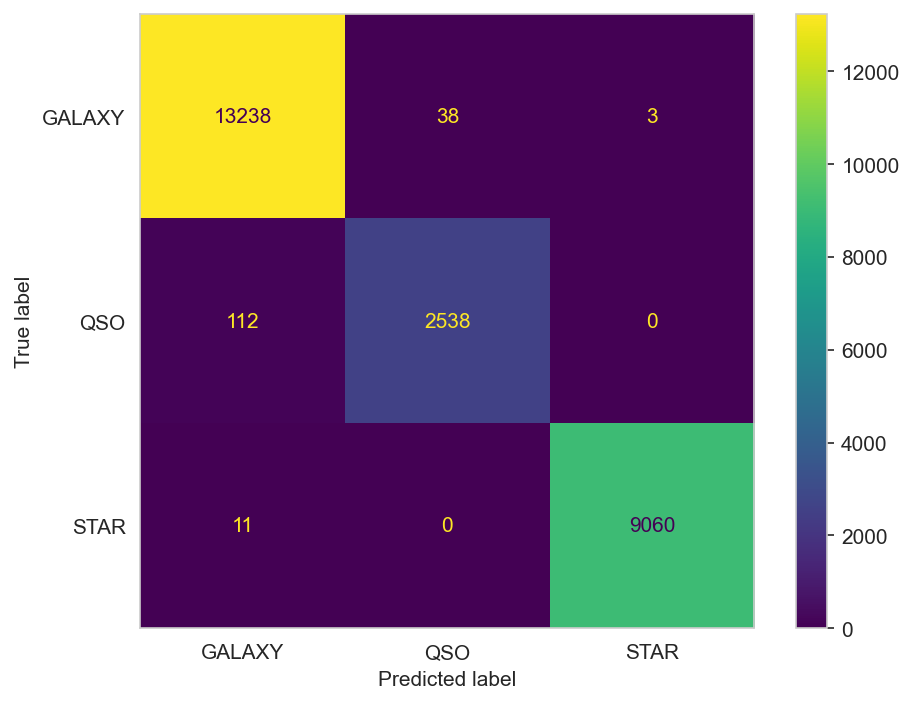

              precision    recall  f1-score   support

      GALAXY     0.9906    0.9966    0.9936     13279
         QSO     0.9841    0.9566    0.9701      2650
        STAR     0.9996    0.9988    0.9992      9071

    accuracy                         0.9932     25000
   macro avg     0.9914    0.9840    0.9876     25000
weighted avg     0.9931    0.9932    0.9931     25000

Accuracy for galaxy: 0.9934
Accuracy for qso: 0.9940
Accuracy for star: 0.9994
Random Forest has accuracy 0.9934 on validation set
Standard Accuracy MLXtend: 0.99344
Binary Galaxy Accuracy MLXtend: 0.99344
Binary Star Accuracy MLXtend: 0.99944
Binary QSO Accuracy MLXtend: 0.994


In [ ]:
accuracy = metrics.accuracy_score(y_val["class"].ravel(),final_y_hat)
conf_matrix_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_val["class"].ravel(),
                                                                   final_y_hat)
plt.rcParams['figure.dpi'] = 150
plt.grid(False)
plt.tight_layout()
plt.savefig("Confusion_matrix.png",format = "png")
plt.show()

print(metrics.classification_report(y_val, y_hat_rf, digits=4))
matrix = conf_matrix_disp.confusion_matrix

tp_galaxy = matrix[0,0]
tn_galaxy = matrix[1,1] + matrix[2,2] + matrix[1,2] + matrix[2,1]
print(f"Accuracy for galaxy: {(tp_galaxy + tn_galaxy)/matrix.sum():.4f}")

tp_qso = matrix[1,1]
tn_qso = matrix[0,0] + matrix[2,2] + matrix[0,2] + matrix[2,0]
print(f"Accuracy for qso: {(tp_qso + tn_qso)/matrix.sum():.4f}")

tp_star = matrix[2,2]
tn_star = matrix[0,0] + matrix[0,1] + matrix[1,0] + matrix[1,1]
print(f"Accuracy for star: {(tp_star + tn_star)/matrix.sum():.4f}")

print(f"Random Forest has accuracy {accuracy:.4g} on validation set")

## Interpretation

In [ ]:
perm_result = inspection.permutation_importance(
    final_model, X_val, y_val, n_jobs=-1, n_repeats=10, random_state=RS)
mean_importances = pd.Series(perm_result.importances_mean,
                                index=X.columns).sort_values(ascending=False)[0:17]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
gini_importances_noised = pd.Series(final_model.named_steps["model"].feature_importances_,
                                    index=X.columns)
gini_importances_noised = gini_importances_noised.sort_values(ascending=False)[0:17].sort_values(
    ascending=True
)
gini_importances_noised.name = "importance"
gini_importances_noised = pd.DataFrame(gini_importances_noised).reset_index()
gini_importances_noised["group"] = gini_importances_noised["index"].apply(
    lambda x: x.split("_")[0]
)
groups = gini_importances_noised["group"].unique()
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(groups)))
group_to_color = {g: colors[i] for i, g in enumerate(groups)}
gini_importances_noised["color"] = gini_importances_noised.group.map(group_to_color)

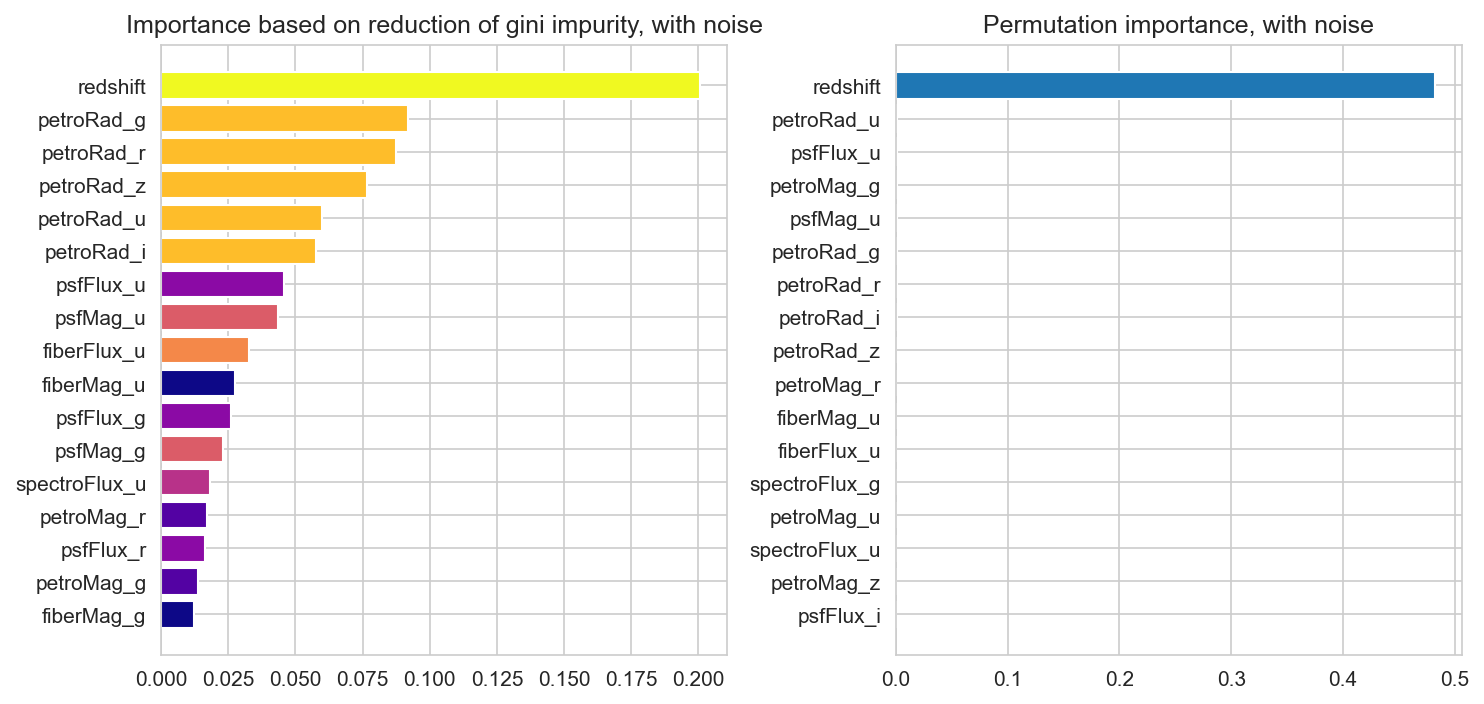

In [ ]:
plot_differences = mean_importances.sort_values(ascending=True)

fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)

ax[0].barh(width=gini_importances_noised.importance,
           y=gini_importances_noised["index"],
           color=gini_importances_noised.color)
ax[0].set_title("Importance based on reduction of gini impurity, with noise")

ax[1].barh(width=plot_differences, y=plot_differences.index)
ax[1].set_title("Permutation importance, with noise")
fig.tight_layout()
fig.savefig("feature-importances.png", dpi=600)
plt.show()

## Estimate of Generalisation Error

In [ ]:
# Train on full data and use out of bag bootstrap samples to measure generalization
final_model.fit(X, y["class"].ravel())
risk_estimate = 1 - final_model.named_steps["model"].oob_score_
print(f"Generalization risk estimate using oob: {risk_estimate:.4g}")

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing noiser, total=   0.1s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   47.2s finished


[Pipeline] ............. (step 3 of 3) Processing model, total=  49.1s
Generalization risk estimate using oob: 0.00662
